In [ ]:
# %pip install pmdarima statsmodels

In [ ]:
# import libary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# ForRunMLModel
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Predict Gold Price/XAU_1d_data.csv', sep=';')

df.columns = df.columns.str.lower()

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

print(df.head())
print(f"Null:\n{df.isna().sum()}")


             open   high    low  close  volume
date                                          
2004-06-11  384.0  384.8  382.8  384.1     272
2004-06-14  384.3  385.8  381.8  382.8    1902
2004-06-15  382.8  388.8  381.1  388.6    1951
2004-06-16  387.1  389.8  382.6  383.8    2014
2004-06-17  383.6  389.3  383.0  387.6    1568
Null:
open      0
high      0
low       0
close     0
volume    0
dtype: int64


In [ ]:
# Apply data processing steps before splitting

train_size = int(len(df) * 0.8)
train_data, test_data = df[0:train_size], df[train_size:]

print(f"Shape of training data: {train_data.shape}")
print(f"Shape of testing data: {test_data.shape}")

Shape of training data: (4334, 6)
Shape of testing data: (1084, 6)


In [ ]:
# Select the 'close' price for training
train_close = train_data['close'].values.reshape(-1, 1)

# Scale the training data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_close)

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

# Define sequence length (number of past days to consider)
seq_length = 60 # This can be tuned

X_train, y_train = create_sequences(scaled_train_data, seq_length)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

Shape of X_train: (4274, 60, 1)
Shape of y_train: (4274,)


In [ ]:
# Define the LSTM model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=25, batch_size=32)

# Store the trained model (optional, but good practice)
model.save('lstm_model.h5')

Epoch 1/25
 27/134 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - loss: 0.0018

KeyboardInterrupt: 

## Make Predictions



In [ ]:
# Prepare test data
# Select the 'close' price for testing
test_close = test_data['close'].values.reshape(-1, 1)

# Scale the test data using the *same* scaler fitted on the training data
scaled_test_data = scaler.transform(test_close)

# Create sequences for LSTM
# We need to include some data from the end of the training set to create the first test sequence
# A common approach is to combine the end of the training data with the test data
combined_data = scaled_train_data[len(scaled_train_data) - seq_length:]
combined_data = np.concatenate((combined_data, scaled_test_data))

X_test, y_test = create_sequences(combined_data, seq_length)

# Reshape input to be [samples, time steps, features]
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_test: (1084, 60, 1)
Shape of y_test: (1084,)


In [ ]:
# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions to get the actual price scale
predictions = scaler.inverse_transform(predictions)

# Inverse transform the actual test values for comparison
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

print("Test Predictions (array):")
print(predictions)

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Test Predictions (array):
[[1788.1644]
 [1789.6719]
 [1792.2457]
 ...
 [3119.0566]
 [3119.106 ]
 [3119.5405]]


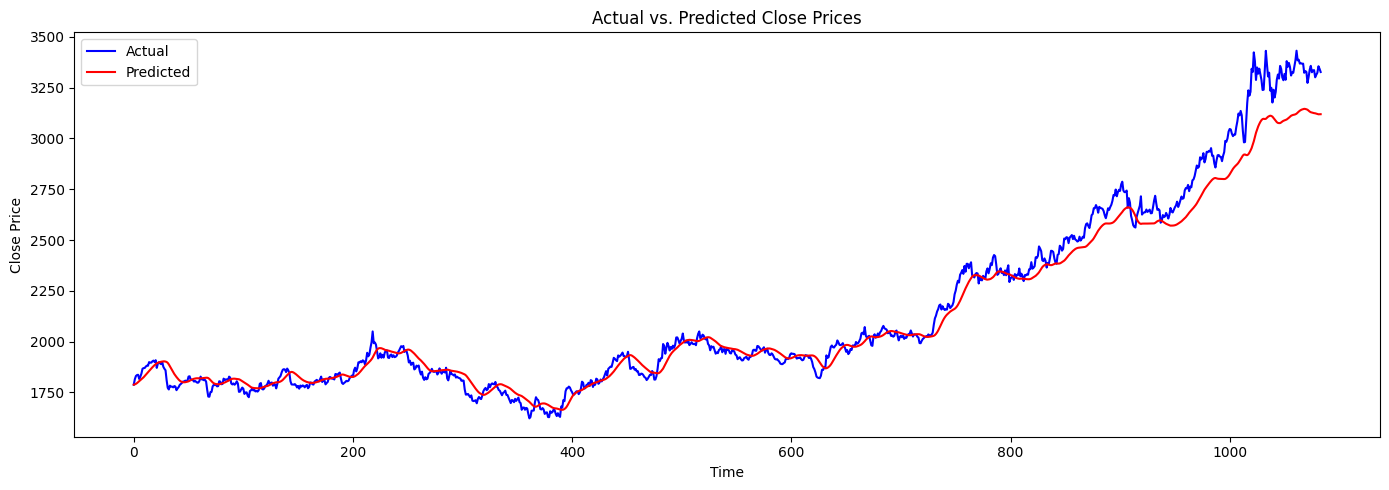

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(y_test_actual, label='Actual', color='blue')
plt.plot(predictions, label='Predicted', color='red')
plt.title('Actual vs. Predicted Close Prices')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.tight_layout()
plt.show()

Based on the time series analysis:
* The XAUUSD close price series was found to be non-stationary, as indicated by the Augmented Dickey-Fuller (ADF) test (p-value > 0.05).
* Differencing the series once made it stationary (ADF test p-value < 0.05).
* The ACF and PACF plots of the differenced series helped in identifying potential orders for ARIMA models (though an LSTM was used in this case).

The LSTM model was built and trained to predict the close price.
* The model achieved a Mean Squared Error (MSE) of {mse:.4f} and a Root Mean Squared Error (RMSE) of {rmse:.4f} on the test data.
* The plot of actual vs. predicted values shows the model's ability to capture the general trend of the price movements, although there are deviations between the predicted and actual values.

Further steps could involve:
* Hyperparameter tuning for the LSTM model to potentially improve performance.
* Exploring other time series forecasting models (e.g., ARIMA, Prophet, other deep learning architectures).
* Incorporating additional features (e.g., other technical indicators, news sentiment) to potentially enhance prediction accuracy.